# 객체 특징 추출

## 라벨링과 특징 파라미터

### 라벨링

In [6]:
def labelset(img, xs, ys, label):
    height, width = img.shape
    img[ys, xs] = label
    while True:
        cnt = 0
        for y in range(1, height-1):
            for x in range(1, width-1):
                if img[y,x] == label :
                    if img[y , x+1] == 255 :
                        img[y , x+1] = label; cnt = cnt+1
                    if img[y-1, x+1] == 255 :
                        img[y-1, x+1] = label; cnt = cnt+1
                    if img[y-1, x ] == 255 :
                        img[y-1, x ] = label; cnt = cnt+1
                    if img[y-1, x-1] == 255 :
                        img[y-1, x-1] = label; cnt = cnt+1
                    if img[y , x-1] == 255 :
                        img[y , x-1] = label; cnt = cnt+1
                    if img[y+1, x-1] == 255 :
                        img[y+1, x-1] = label; cnt = cnt+1
                    if img[y+1, x ] == 255 :
                        img[y+1, x ] = label; cnt = cnt+1
                    if img[y+1, x+1] == 255 :
                        img[y+1, x+1] = label; cnt = cnt+1
        if cnt==0:
            return (0, img)
    return (1, img)

In [7]:
def labeling(img_in, base=100):
    height, width = img_in.shape
    img_label = img_in.copy()

    label = base # 베이스값부터 라벨링 함

    for y in range(1, height-1):
        for x in range(1, width-1):
            if img_label[y,x] == 255 :
                if label >= 255:
                    print("Error! too many labels")
                    return -1

                _, img_label = labelset(img_label, x, y, label)
                label = label + 1
    cnt = label - base

    return img_label, cnt

In [8]:
import cv2

img = cv2.imread('images/shape.png',0)
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

labeled_img, cnt = labeling(bin_img)

print("객체 수", cnt)
print(labeled_img[80, 80], end=" ")
print(labeled_img[69,173], end=" ")
print(labeled_img[160,190], end=" ")
print(labeled_img[160,60])
cv2.imshow('image', img)
cv2.imshow('Labeling', labeled_img)
cv2.waitKey()
cv2.destroyAllWindows()

객체 수 4
100 101 102 103


In [10]:
import cv2
import numpy as np

img = cv2.imread('images/shape.png', 0)
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
cnt, labeled_img = cv2.connectedComponents(bin_img)

print(labeled_img[80, 80], end=" ")
print(labeled_img[69, 173], end=" ")
print(labeled_img[160, 190], end=" ")
print(labeled_img.dtype)

labeled_img = labeled_img * 50
cv2.imshow('Labeling', labeled_img.astype(np.uint8))
cv2.waitKey()
cv2.destroyAllWindows()

1 2 3 int32


In [17]:
def calc_size(img_label, label):
    tx, ty = 0, 0
    cx, cy = 0, 0 # 반환할 중심점
    total = 0
    height, width = img_label.shape
    for y in range(height):
        for x in range(width):
            if img_label[y,x]==label:
                tx = tx + x
                ty = ty + y
                total = total + 1
    if total==0:
        return 0
    cx = int(tx/total)
    cy = int(ty/total)
    return (cx, cy, total)

### 주위 길이 계산

In [18]:
import numpy as np

def trace(img_label, xs, ys):
    length = 0
    x, y = xs, ys
    no = img_label[y, x+1]
    vec = 5
    
    while True:
        if x == xs and y == ys and length != 0:
            return (length, img_label)
        img_label[y, x] = 255
        
        if vec == 3:
            if img_label[y, x+1] != no and img_label[y-1, x+1] == no:
                x = x + 1
                y = y
                length += 1
                vec = 0
                continue
            else:
                vec = 4
                
        if vec == 4:
            if img_label[y-1, x+1] != no and img_label[y-1, x] == no:
                x = x + 1
                y = y - 1
                length += np.sqrt(2)
                vec = 1
                continue
            else:
                vec = 5
                
        if vec == 5:
            if img_label[y-1, x] != no and img_label[y-1, x-1] == no:
                x = x
                y = y -1
                length += 1
                vec = 2
                continue
            else:
                vec = 6
                
        if vec == 6:
            if img_label[y-1, x-1] != no and img_label[y, x-1] == no:
                x = x -1
                y = y -1
                length += np.sqrt(2)
                vec = 3
                continue
            else:
                vec = 7
                
        if vec == 7:
            if img_label[y, x-1] != no and img_label[y+1, x-1] == no:
                x = x - 1
                y = y
                length += 1
                vec = 4
                continue
            else:
                vec = 0
        
        if vec == 0:
            if img_label[y+1, x-1] != no and img_label[y+1, x] == no:
                x = x - 1
                y = y + 1
                length += np.sqrt(2)
                vec = 5
                continue
            else:
                vec = 1
                
        if vec == 1:
            if img_label[y+1, x] != no and img_label[y+1, x+1] == no:
                x = x
                y = y + 1
                length += 1
                vec = 6
                continue
            else:
                vec = 2
                
        if vec == 2:
            if img_label[y+1, x+1] != no and img_label[y, x+1] == no:
                x = x + 1
                y = y + 1
                length += np.sqrt(2)
                vec = 7
                continue
            else:
                vec = 3

In [22]:
def calc_length(img_label, label):
    height, width = img_label.shape
    for y in range(height):
        for x in range(width):
            if img_label[y, x] == label:
                length, img_label = trace(img_label, x-1, y)
                return length, img_label

### 원형도

In [23]:
import numpy as np

def features(img_label, cnt):
    areas = []; centers = []; lengths = []; ratios = []
    featured_img = np.zeros(img_label.shape, dtype=np.uint8)
    for i in range(cnt):
        cx, cy, area = calc_size(img_label, i+100)
        centers.append((cx, cy)); areas.append(area)
        length, featured_img = calc_length(img_label, i+100)
        lengths.append(length)
        ratio = 4*np.pi*area / (length*length)
        ratios.append(ratio)

    return ((areas, centers, lengths, ratios), featured_img)

In [25]:
import cv2

img = cv2.imread('images/shape.png', 0)
_, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
labeled_img, cnt = labeling(bin_img, 100)
feat, featured_img = features(labeled_img, cnt)
areas, centers, lengths, ratios = feat

print(areas)
print(centers)
print(lengths)
print(ratios)

cv2.imshow('image', featured_img)
cv2.waitKey()
cv2.destroyAllWindows()

[4880, 1797, 1108, 2759]
[(76, 79), (172, 87), (192, 168), (81, 163)]
[263.7645019878176, 226.99494936611694, 168.2253967444163, 241.6568542494924]
[0.8814486001080429, 0.4382536609116099, 0.49200158512447256, 0.5936949146124189]


### OpenCV를 이용한 특징 추출

In [28]:
# 경계를 찾고 그리는 함수
import cv2
img = cv2.imread('images/shape.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, bin_img = cv2.threshold(imgray, 127, 255, 0)

contours, hierachy = cv2.findContours(bin_img,
                                     cv2.RETR_TREE,
                                     cv2.CHAIN_APPROX_SIMPLE)
image = cv2.drawContours(img, contours, -1, (0,255,0), 3)

cv2.imshow('image', image)
cv2.waitKey()
cv2.destroyAllWindows()

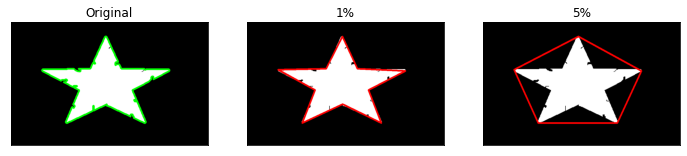

In [30]:
#경계 근사를 찾는 함수

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/star.png')
img1 = img.copy()
img2 = img.copy()

imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, bin_img = cv2.threshold(imgray,127,255,0)

contours, hierachy = cv2.findContours(bin_img, cv2.RETR_TREE,
cv2.CHAIN_APPROX_SIMPLE)
cont = contours[0]

epsilon1 = 0.01*cv2.arcLength(cont, True)
epsilon2 = 0.05*cv2.arcLength(cont, True)

approx1 = cv2.approxPolyDP(cont, epsilon1, True)
approx2 = cv2.approxPolyDP(cont, epsilon2, True)

cv2.drawContours(img, [cont], 0, (0,255,0), 5)
cv2.drawContours(img1, [approx1], 0,(255,0,0), 5)
cv2.drawContours(img2, [approx2], 0,(255,0,0), 5)

titles = ['Original', '1%', '5%']
images = [img, img1, img2]

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(titles[i])
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

## 객체 탐지

### 경계상자

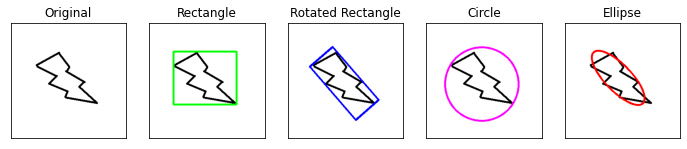

In [33]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/lightning.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bin_img = cv2.threshold(imgray, 127, 255, 0)
contours, hierachy = cv2.findContours(bin_img, cv2.RETR_TREE,
cv2.CHAIN_APPROX_SIMPLE)
cont = contours[1] # 0번째 컨투어는 이미지 전체

x, y, w, h = cv2.boundingRect(cont)
img_rect = cv2.rectangle(img.copy(), (x,y), (x+w,y+h),
(0,255,0), 3)

rect = cv2.minAreaRect(cont)
box = np.int_(cv2.boxPoints(rect))
img_rotated_rect = cv2.drawContours(img.copy(), [box], 0,
(0,0,255), 3)

(x,y), radius = cv2.minEnclosingCircle(cont)
center = (int(x), int(y))
radius = int(radius)
img_circle = cv2.circle(img.copy(), center, radius,
(255,0,255), 3)

ellipse = cv2.fitEllipse(cont)
img_ellipse = cv2.ellipse(img.copy(), ellipse, (255,0,0), 3)

titles = ['Original', 'Rectangle',
'Rotated Rectangle','Circle','Ellipse']
images = [img, img_rect, img_rotated_rect, img_circle,
img_ellipse]
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1, 5, i+1), plt.imshow(images[i]),
    plt.title(titles[i]), plt.xticks([]), plt.yticks([])
plt.show()

## OpenCV와 머신러닝 활용한 필기체 숫자 인식

In [34]:
import cv2
import numpy as np

img = cv2.imread('images/digits.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)

(1000, 2000)


In [35]:
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]
x = np.array(cells)
print(x.shape)

(50, 100, 20, 20)


In [36]:
X = x[:,:].reshape(-1,400).astype(np.float32)
y = np.repeat(np.arange(10),500)

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y,
test_size=0.3)

In [38]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(train_X, train_y)
print(model.score(test_X, test_y))

0.9393333333333334


In [44]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)
if cap.isOpened():
    while True:
        ret, img = cap.read()
        if ret:
            g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            _, bin_img = cv2.threshold(g_img, 110, 255,
                                      cv2.THRESH_BINARY_INV)
            contours, hierarchy = cv2.findContours(bin_img,
                                                  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            try:
                for contour in contours:
                    (x,y), radius = cv2.minEnclosingCircle(contour)
                    if radius > 5:
                        xs, xe = int(x-radius), int(x+radius)
                        ys, ye = int(y-radius), int(y+radius)
                        cv2.rectangle(bin_img, (xs,ys),(xe,ye), (255,0,0), 1)
                        roi = bin_img[ys:ye, xs:xe]
                        dst = cv2.resize(roi, dsize=(50, 50),interpolation=cv2.INTER_AREA)
                        dst = cv2.resize(dst, dsize=(16, 16),interpolation=cv2.INTER_AREA)
                        A = np.zeros((20,20))
                        A[2:-2,2:-2] = dst[:,:]
                        A = A.reshape(-1,400)
                        num = model.predict(A)
                        cv2.putText(bin_img, str(num), (xs, ys),
                        cv2.FONT_HERSHEY_PLAIN,2, (255,0,0))
            except Exception as e:
                print(e)
            cv2.imshow("Image", bin_img)
            if cv2.waitKey(1)&0xFF == 27: # ESC
                break
        else:
            print("No Frame")
            break
else :
    print("Camera not opened")

cap.release()
cv2.destroyAllWindows()


OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\ope

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.5.5) D:\a\ope

OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

